In [1]:
infile1 = "/g/data1/r87/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/historicalMisc/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_historicalMisc_r1i1p1_185001-185912.nc"
infile2 = "/g/data1/r87/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/historicalMisc/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_historicalMisc_r1i1p1_186001-186912.nc"
allfiles = "/g/data1/r87/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/historicalMisc/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_historicalMisc_r1i1p1_*.nc"

## Reading multiple files with xarray

From [the documentation](http://xarray.pydata.org/en/stable/dask.html): `xarray` uses Dask, which divides arrays into many small pieces, called chunks, each of which is presumed to be small enough to fit into memory.

Unlike NumPy, which has eager evaluation, operations on dask arrays are lazy. Operations queue up a series of taks mapped over blocks, and no computation is performed until you actually ask values to be computed (e.g., to print results to your screen or write to disk).

In [2]:
import xarray

In [3]:
ds = xarray.open_mfdataset(allfiles)   #chunks={'lon': 48, 'time': None})

In [4]:
print ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 189, lev: 31, lon: 192, time: 1956)
Coordinates:
  * lev        (lev) float64 5.0 15.0 28.25 42.02 59.66 78.54 102.1 127.9 ...
  * lat        (lat) float64 -88.2 -87.24 -86.3 -85.36 -84.42 -83.49 -82.55 ...
  * lon        (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * bnds       (bnds) int64 0 1
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 1850-02-15 ...
Data variables:
    time_bnds  (time, bnds) float64 0.0 31.0 31.0 59.0 59.0 90.0 90.0 120.0 ...
    lat_bnds   (time, lat, bnds) float64 -90.0 -87.71 -87.71 -86.77 -86.77 ...
    lon_bnds   (time, lon, bnds) float64 -0.9375 0.9375 0.9375 2.812 2.812 ...
    lev_bnds   (time, lev, bnds) float64 0.0 10.0 10.0 21.62 21.62 35.14 ...
    thetao     (time, lev, lat, lon) float64 nan nan nan nan nan nan nan nan ...
Attributes:
    institution: Australian Commonwealth Scientific and Industrial Research Organization (CSIRO) Marine and Atmospheric Research (Melbour

In [5]:
ds.chunks

Frozen(SortedKeysDict({u'lat': (189,), u'bnds': (2,), u'lon': (192,), u'lev': (31,), u'time': (120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 36)}))

In [6]:
ds.nbytes * (2 ** -30)

16.406008556485176

So there's 16.4 GB of data, according to the conversion that Stephan Hoyer does at [this blog post](https://www.continuum.io/content/xray-dask-out-core-labeled-arrays-python).

### Eager evaluation

From [the documentation](http://xarray.pydata.org/en/stable/dask.html): You can convert an xarray data structure from lazy dask arrays into eager, in-memory numpy arrays using the `load()` method (i.e. `ds.load()`), or make it a numpy array using the `values` method of `numpy.asarray()`.

In [7]:
import numpy

In [8]:
darray = ds['thetao']

In [9]:
print darray

<xarray.DataArray 'thetao' (time: 1956, lev: 31, lat: 189, lon: 192)>
dask.array<concate..., shape=(1956, 31, 189, 192), dtype=float64, chunksize=(120, 31, 189, 192)>
Coordinates:
  * lev      (lev) float64 5.0 15.0 28.25 42.02 59.66 78.54 102.1 127.9 ...
  * lat      (lat) float64 -88.2 -87.24 -86.3 -85.36 -84.42 -83.49 -82.55 ...
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 1850-02-15 ...
Attributes:
    standard_name: sea_water_potential_temperature
    long_name: Sea Water Potential Temperature
    units: K
    original_name: Temp
    comment: Data is stored on the native ocean T-grid on which the data was generated. (MOM2 uses a rectangular staggered grid with T cells and U cells.)
    original_units: celsius
    cell_methods: time: mean
    cell_measures: area: areacello volume: volcello
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_

In [10]:
climatology_eager = darray.values.mean(axis=0)

MemoryError: 

### Lazy evaluation

In [11]:
climatology_lazy = ds.mean('time')

In [12]:
%%time 

climatology_lazy.to_netcdf("/g/data/r87/dbi599/lazy.nc")

/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/dask/array/numpy_compat.py:44: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


CPU times: user 34.4 s, sys: 20.1 s, total: 54.5 s
Wall time: 30.9 s


Notice that the computation used only 25 seconds of wall clock time, but 47 seconds of CPU time. It's definitely using 2 cores.

In [26]:
ds.apply?

#### Applying a function in a lazy manner

In [16]:
% matplotlib inline

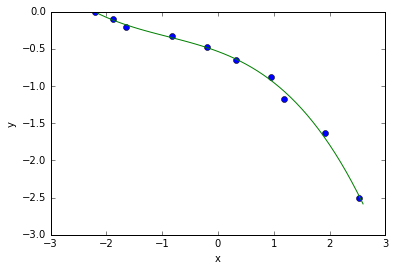

In [18]:
import matplotlib.pyplot as plt

x = [2.53240, 1.91110, 1.18430, 0.95784, 0.33158,
     -0.19506, -0.82144, -1.64770, -1.87450, -2.2010]

y = [-2.50400, -1.62600, -1.17600, -0.87400, -0.64900,
     -0.477000, -0.33400, -0.20600, -0.10100, -0.00600]

coefficients = numpy.polyfit(x, y, 3)
polynomial = numpy.poly1d(coefficients)
xs = numpy.arange(-2.2, 2.6, 0.1)
ys = polynomial(xs)

plt.plot(x, y, 'o')
plt.plot(xs, ys)
plt.ylabel('y')
plt.xlabel('x')
plt.show()

In [23]:
ds.thetao

<xarray.DataArray 'thetao' (time: 1956, lev: 31, lat: 189, lon: 192)>
dask.array<concate..., shape=(1956, 31, 189, 192), dtype=float64, chunksize=(120, 31, 189, 192)>
Coordinates:
  * lev      (lev) float64 5.0 15.0 28.25 42.02 59.66 78.54 102.1 127.9 ...
  * lat      (lat) float64 -88.2 -87.24 -86.3 -85.36 -84.42 -83.49 -82.55 ...
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 1850-02-15 ...
Attributes:
    standard_name: sea_water_potential_temperature
    long_name: Sea Water Potential Temperature
    units: K
    original_name: Temp
    comment: Data is stored on the native ocean T-grid on which the data was generated. (MOM2 uses a rectangular staggered grid with T cells and U cells.)
    original_units: celsius
    cell_methods: time: mean
    cell_measures: area: areacello volume: volcello
    associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_

In [25]:
def cubic_fit(data_series):
    """Fit a cubic polynomial to a 1D numpy array."""
    
    x = numpy.arange(0, len(data_series))
        
    coefficients = numpy.polyfit(x, data_series, 3)
    polynomial = numpy.poly1d(coefficients)

    return polynomial(x)


def cubic_fit_ds(dataset):
    """Fit a cubic polynomial to an xarray dataset."""

    return numpy.apply_along_axis(cubic_fit, 0, ds.thetao.values)

In [27]:
ds.apply(cubic_fit_ds)

MemoryError: 

Traceback
---------
  File "/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/dask/async.py", line 264, in execute_task
    result = _execute_task(task, data)
  File "/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/dask/async.py", line 246, in _execute_task
    return func(*args2)
  File "/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/dask/array/core.py", line 50, in getarray
    c = np.asarray(c)
  File "/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/numpy/core/numeric.py", line 474, in asarray
    return array(a, dtype, copy=False, order=order)
  File "/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/xarray/core/indexing.py", line 312, in __array__
    return np.asarray(array[self.key], dtype=None)
  File "/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/xarray/conventions.py", line 359, in __getitem__
    self.scale_factor, self.add_offset, self._dtype)
  File "/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/xarray/conventions.py", line 57, in mask_and_scale
    values = np.array(array, dtype=dtype, copy=True)
